# Raport MLP - Bartosz Rożek 298839

Przez pierwsze 6 tygodni naszym zadaniem było zaprogramowanie sieci perceptronu wielowarstwowego. 

Raport może trochę różnić się od wcześniejszych skryptów które oddałem, przede wszystkim dodałem PD2, a poza tym to np. dopiero przy PD5 zauważyłem, że normalizacja bardzo poprawia klasyfikację, więc dodałem to do części raportowej PD4 itp..

Raport jest zbudowany następująco:
    
    Klasa MLP z opisem zmiennych i funkcji
    Tydzień [1-6]:
        Opis polecenia
        Przeprowadzone testy
        Wykresy i ich opisy
        Podsumowanie pracy domowej - czego sie nauczyłem, co pokazało ćwiczenie

In [3]:
class MLP:
    """
    layers - wektor zawierający liczbę kolejnych neuronów warstwach, w tym wejscie i wyjscie
    weights_biases - wybor metody losowania wag
    activation_function - funkcja aktywacji
    activation_function_der - pochodna funkcja aktywacji
    delta_w, delta_b - zmiana biasu i wag w propagacji wstecznej
    softmax_metod - zastosowanie softmax na ostatniej warstwie
    """
    
    
    def __init__(self, layers, weights_biases, activation_function, softmax_method = False, regularization = "none"):
        self.layers = layers
        self.softmax_method = softmax_method
        self.weights = []
        self.biases = []
        self.delta_w = []
        self.delta_b = []
        
        if activation_function == "sigmoid":
            self.activation_function = self.sigmoid
            self.activation_function_der = self.sigmoid_der
        elif activation_function == "linear":
            self.activation_function = self.linear
            self.activation_function_der = self.linear_der
        elif activation_function == "tanh":
            self.activation_function = self.tanh
            self.activation_function_der = self.tanh_der
        elif activation_function == "relu":
            self.activation_function = self.relu
            self.activation_function_der = self.relu_der

        if weights_biases == "Random":
            self.weights_random()
        elif weights_biases == "Xavier": 
            self.weights_xavier()
        
    def weights_random(self):
        """
        losowanie wag z rozkladu jednostajnego z przedzialu [-1,1] 
        """
        for i in range(len(self.layers) - 1):
            self.weights.append(np.random.uniform(
                -1, 1, self.layers[i] * self.layers[i + 1]).reshape(layers[i], self.layers[i + 1]))
            self.biases.append(np.random.uniform(-1, 1, self.layers[i + 1]).reshape(1, self.layers[i+1]))
            
    def weights_xavier(self):
        """
        losowanie wag metodą Xaviera
        """
        xavier = np.sqrt(6)/np.sqrt(self.layers[1]+self.layers[-1])
        for i in range(len(self.layers) - 1):
            self.weights.append(xavier * np.random.uniform(
                -1, 1, self.layers[i] * self.layers[i + 1]).reshape(layers[i], self.layers[i + 1]))
            self.biases.append(xavier * np.random.uniform(-1, 1, self.layers[i + 1]).reshape(1, self.layers[i+1]))

    
    def forward(self, inputs):
        """
        przejscie do przodu po sieci 
        """
        self.A = []
        self.z = []

        a = inputs
        self.A.append(a)
        for i in range(len(self.layers)-2):

            outputs = a @ self.weights[i] + self.biases[i]
            self.z.append(outputs)
            a = self.activation_function(outputs)
            self.A.append(a)
        results = a @ self.weights[-1] + self.biases[-1]
        if self.softmax_method:
            results = self.softmax(results)
        self.z.append(results)
        self.A.append(results)
        return results

    def backward(self, y):
        """
        propagacja wsteczna
        """
        m = y.shape[0]
        D = [None] * len(self.weights)
        
        if self.softmax_method:
            temp = []
            for a, y_ in zip(self.A[-1], y):
                error = y_ - a
                a_ = a.reshape(a.shape[0], )
                si_sj = - a_ * a_.reshape(self.layers[-1], 1)
                sof_der = np.diag(a_) + si_sj
                temp.append(sof_der @ error)

            temp = np.array(temp)
            D[-1] = temp
        
        else:
            D[-1] = y - self.A[-1]
        
        
        for i in reversed(range(len(D) - 1)):
            D[i] = ((self.weights[i + 1] @ D[i + 1].T ) * self.activation_function_der(self.z[i]).T).T

        delta_b = [None] * len(D)
        delta_w = [None] * len(D)
        
        for i, d in enumerate(D):
            delta_w[i] = (d.T @ self.A[i]).T / m
            delta_b[i] = (d.T @ np.ones((m, 1))).T / m

        return delta_w, delta_b

    def learn(self, x, y, batch_size=20, iterations=500, alpha=0.01, 
              method = "Classic", var=0.4, lambda_=0, inc_stop = False):
        """
        alpha - learning rate
        method - wybór metody uczenia Classic(default)/Momentum/RMSProp
        var - współczynnik wygaszania
        """
        
        p = np.random.permutation(len(x))
        x = x[p]
        y = y[p]
        tr = math.floor(0.9*len(x))
        x_test = x[tr:]
        y_test = y[tr:]
        x = x[:tr]
        y = y[:tr]
        
        m = x.size
        
        min_error = math.inf
        current_error = 0
        
        method_w = [np.zeros(w.shape) for w in self.weights]
        method_b = [np.zeros(b.shape) for b in self.biases]

        for iteration in range(iterations):
            i = 0
            
            while i < len(y):
                x_batch = x[i:i + batch_size]
                y_batch = y[i:i + batch_size]
                i = i + batch_size
                self.forward(x_batch)
                delta_w, delta_b = self.backward(y_batch)
                
                if method == "Classic":
                    for j, weight in enumerate(self.weights):    
                        self.weights[j] = weight + alpha * delta_w[j]
                    
                    for j, bias in enumerate(self.biases):
                        self.biases[j] = bias + alpha * delta_b[j]   
                
                elif method == "Momentum":
                    for j, weight in enumerate(self.weights):    
                        method_w[j] = method_w[j] * var + delta_w[j]
                        self.weights[j] = weight + alpha * method_w[j]
                    
                    for j, bias in enumerate(self.biases):
                        method_b[j] = method_b[j] * var + delta_b[j]
                        self.biases[j] = bias + alpha * method_b[j]
                        
                elif method == "RMSProp":
                    for j, weight in enumerate(self.weights):    
                        method_w[j] = var * method_w[j] + (1-var) * delta_w[j] ** 2
                        self.weights[j] = weight + alpha * (delta_w[j]/np.sqrt(method_w[j]) + 10**-8)
                    
                    for j, bias in enumerate(self.biases):
                        method_b[j] = var * method_b[j] + (1-var) * delta_b[j] ** 2
                        self.biases[j] = bias + alpha * (delta_b[j]/np.sqrt(method_b[j]) + 10**-8)
            current_error = 1/m * mean_squared_error(self.forward(x_test), y_test) + lambda_ * sum([np.sum(np.abs(x)) + np.sum(np.abs(y)) for x,y in zip(self.weights,self.biases)]) / (2*m)
            if (inc_stop * current_error > 1.5 * min_error):
                break
            if (current_error < min_error):
                min_error = current_error
                
    def classify(self,x):
        probability = self.forward(x)
        return [i.argmax() for i in probability]
    
    
    @staticmethod
    def sigmoid(x):
        z = np.array(x)
        return 1 / (1 + np.exp(-z))
    
    @staticmethod
    def sigmoid_der(x):
        return MLP.sigmoid(x) * (1 - MLP.sigmoid(x))
    
    @staticmethod
    def softmax(x):
        e_x = np.exp(x.T - np.max(x, axis=1).T).T
        return (e_x.T / e_x.sum(axis=1).T).T
    
    @staticmethod
    def linear(x):
        return np.array(x)
    
    @staticmethod
    def linear_der(x):
        return np.ones(x.shape)
    
    @staticmethod
    def tanh(x):
        return np.tanh(x)
    
    @staticmethod
    def tanh_der(x):
        return 1/np.cosh(x)**2
    
    @staticmethod
    def relu(x):
        z = np.array(x)    
        return np.maximum(0,z)
    
    @staticmethod
    def relu_der(x):
        z = np.array(x)    
        z[z<0]=0
        z[z!=0] = 1
        return z


## Tydzień 1. - bazowa implementacja

W pierwszym tygodniu mieliśmy podłożyć podwaliny pod przyszłą pracę - zaimplementować funkcję <em> forward </em>. Parametry trzeba było dobrać ręcznie, co sprawiło dużo problemów i zabrało sporo czasu. 

Testy przeprowadzone zostały na zbiorach: 

    square-simple
    steps-large 

Sprawdziłem 3 struktury :

    jedna warstwa ukryta, 5 neuronów,
    jedna warstwa ukryta, 10 neuronów,
    dwie warstwy ukryte, po 5 neuronów


### Zbiór square-simple

#### Jedna warstwa 5 neuronów

In [8]:
train_df = pd.read_csv('mio_data/regression/square-simple-training.csv', index_col=0)
test_df = pd.read_csv('mio_data/regression/square-simple-test.csv', index_col=0)

x = np.asarray(train_df['x']).reshape(-1, 1)
y = np.asarray(train_df['y']).reshape(-1, 1)

x_test = np.asarray(test_df['x']).reshape(-1,1)
y_test = np.asarray(test_df['y']).reshape(-1, 1)

In [57]:
layers = [1,5,1]
mlp = MLP(
        layers = layers, 
        weights_biases = "Random",
        activation_function = "sigmoid", 
        softmax_method = False)

In [87]:
wagi = [np.array([[2, 1, -1, -1, -1]]), np.array([[-700, -100, -50, -800, -300]]).reshape(-1,1)]
biases = [np.array([[1, 1, 1, 1, 1]]), np.array([[ 1300]]).reshape(-1,1)]

mlp.weights = wagi
mlp.biases = biases

In [88]:
pred = mlp.forward(x_test)

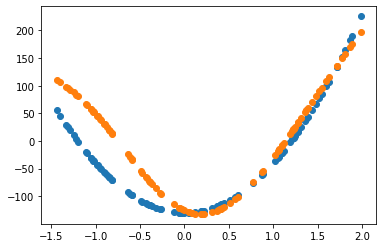

In [93]:
plt.scatter(x_test, y_test)
plt.scatter(x_test, pred)

In [96]:
print("MAE na zbiorze: \ntreningowym: ", metrics.mean_absolute_error(y, mlp.forward(x)),
     "\ntestowym: ", metrics.mean_absolute_error(y_test, mlp.forward(x_test)))

MAE na zbiorze: 
treningowym:  26.052701103447326 
testowym:  35.0555117188554


Funkcja wydaje się w miarę dobrze przybliżania patrząc na kształt krzywych.

#### Jedna warstwa 10 neuronów

In [99]:
layers = [1,10,1]
mlp = MLP(
        layers = layers, 
        weights_biases = "Random",
        activation_function = "sigmoid", 
        softmax_method = False)

In [100]:
wagi = [np.array([[2, 1, -1, -1, -1, 100, 1, 1, 1, 1]]),
        np.array([[-700, -100, -50, -800, -300, 100 , 1, 1 , 100, 1]]).reshape(-1,1)]
biases = [np.array([[1, 1, 1, 1, 10, 1 , 1, 1 , 1, 1]]), 
          np.array([[ 1300]]).reshape(-1,1)]

mlp.weights = wagi
mlp.biases = biases

In [101]:
pred = mlp.forward(x_test)

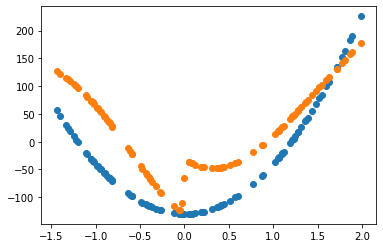

In [102]:
plt.scatter(x_test, y_test)
plt.scatter(x_test, pred)

In [103]:
print("MAE na zbiorze: \ntreningowym: ", metrics.mean_absolute_error(y, mlp.forward(x)),
     "\ntestowym: ", metrics.mean_absolute_error(y_test, mlp.forward(x_test)))

MAE na zbiorze: 
treningowym:  54.76018909021288 
testowym:  62.12909485839453


Sieć neuronowa tworzy dziwny skok i słabo przybliża dany zbiór.

#### Dwie warstwy po 5 neuronów

In [104]:
layers = [1,5,5,1]
mlp = MLP(
        layers = layers, 
        weights_biases = "Random",
        activation_function = "sigmoid", 
        softmax_method = False)

In [124]:
wagi = [np.array([[2, 1, -1, -1, -1]]),
        np.array([[2, 1, -1, -1, -1],
                  [10, 1, 1, 1, 10],
                  [10, 1, 1, 1, 10],
                  [10, 1, 1, 1, 10],
                  [10, 1, 1, 1, 10]]),
        np.array([[-700, -100, -50, -800, -300]]).reshape(-1,1)]

biases = [np.array([[1, 1, 1, 1, 10]]), 
          np.array([[1, 1, 1, 1, 10]]),
          np.array([[ 1900]]).reshape(-1,1)]

mlp.weights = wagi
mlp.biases = biases

In [125]:
pred = mlp.forward(x_test)

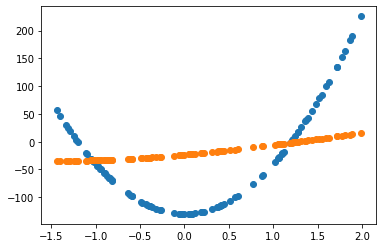

In [126]:
plt.scatter(x_test, y_test)
plt.scatter(x_test, pred)

In [127]:
print("MAE na zbiorze: \ntreningowym: ", metrics.mean_absolute_error(y, mlp.forward(x)),
     "\ntestowym: ", metrics.mean_absolute_error(y_test, mlp.forward(x_test)))

MAE na zbiorze: 
treningowym:  77.52155929964115 
testowym:  65.49927078727983


Fatalne przybliżenie paraboli prostą.

### Zbiór steps-large

In [132]:
train_df = pd.read_csv('mio_data/regression/steps-large-training.csv', index_col=0)
test_df = pd.read_csv('mio_data/regression/steps-large-test.csv', index_col=0)

x = np.asarray(train_df['x']).reshape(-1, 1)
y = np.asarray(train_df['y']).reshape(-1, 1)

x_test = np.asarray(test_df['x']).reshape(-1,1)
y_test = np.asarray(test_df['y']).reshape(-1, 1)

#### Jedna warstwa 5 neuronów

In [133]:
layers = [1,5,1]
mlp = MLP(
        layers = layers, 
        weights_biases = "Random",
        activation_function = "sigmoid", 
        softmax_method = False)

In [138]:
wagi = [np.array([[50, 180, 180, 150, 450]]), np.array([[100, 80, 80, 100, 0]]).reshape(-1,1)]
biases = [np.array([[450, -100, 100, -115, 150]]), np.array([[ -180]]).reshape(-1,1)]

mlp.weights = wagi
mlp.biases = biases

In [139]:
pred = mlp.forward(x_test)

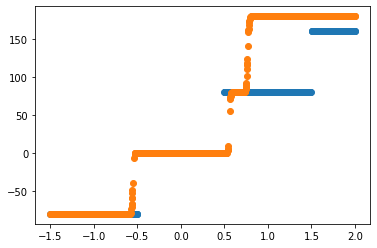

In [140]:
plt.scatter(x_test, y_test)
plt.scatter(x_test, pred)

In [141]:
print("MAE na zbiorze: \ntreningowym: ", metrics.mean_absolute_error(y, mlp.forward(x)),
     "\ntestowym: ", metrics.mean_absolute_error(y_test, mlp.forward(x_test)))

MAE na zbiorze: 
treningowym:  26.752308689779717 
testowym:  26.599417386283093


Sieć neuronowa bardzo dobrze pokrywa dwa pierwsze stopnie, jednak nie daje sobie rady z pozostałymi.

Zdecydowałem się pominąć strojenie wag dla pozostałych architekur, ponieważ nie różni się to zbytnio od pierwszego zbioru.

### Podsumowanie PD 1

Pierwsza praca domowa pozwoliła mi zaprogramować przejście po sieci do przodu, co z znaczącym stopniu ułatwiło zrozumienie tego procesu. Strojenie wag ręcznie jest zadaniem pochłaniającym wiele czasu i energii. Zobaczyłem, że konieczne jest zaimplementowanie algorytmów strojących sieć, aby móc w jakikolwiek efektywny sposób z niej korzystać. 

## Tydzień 2. - Implementacja propagacji wstecznej błędu 

W tygodniu drugim należało zaprogramować propagację wsteczną błędu - algorytm pozwalający na strojenie wag. 
Dodatkowo mieliśmy zaimplementować losowe inicjowanie wag (oprócz rozkładu jednostajnego dodałem także metodę Xavier). 

Testy implementacji przeprowadziłem na zbiorach:

    square-simple 
    steps-small
    multimodal-large


### Zbiór square-simple

In [156]:
train_df = pd.read_csv('mio_data/regression/square-simple-training.csv', index_col=0)
test_df = pd.read_csv('mio_data/regression/square-simple-test.csv', index_col=0)

x = np.asarray(train_df['x']).reshape(-1, 1)
y = np.asarray(train_df['y']).reshape(-1, 1)

x_test = np.asarray(test_df['x']).reshape(-1,1)
y_test = np.asarray(test_df['y']).reshape(-1, 1)

In [163]:
layers = [1,10,1]
mlp = MLP(
        layers = layers, 
        weights_biases = "Random",
        activation_function = "sigmoid", 
        softmax_method = False)

In [164]:
mlp.learn(x, y, batch_size=100, iterations=10000, alpha=0.001, method = "Classic")
pred = mlp.forward(x_test)

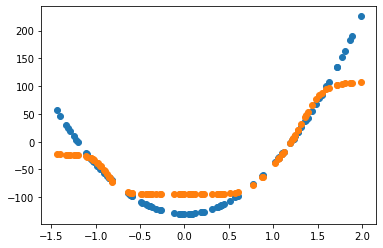

In [165]:
plt.scatter(x_test, y_test)
plt.scatter(x_test, pred)

In [166]:
print("MAE na zbiorze: \ntreningowym: ", metrics.mean_absolute_error(y, mlp.forward(x)),
     "\ntestowym: ", metrics.mean_absolute_error(y_test, mlp.forward(x_test)))

MAE na zbiorze: 
treningowym:  23.645311714095772 
testowym:  19.034274283072172


Widzimy, że na dwóch przedziałach funkcja jest dobrze przybliżona.

### Zbiór steps-small

In [167]:
train_df = pd.read_csv('mio_data/regression/steps-small-training.csv', index_col=0)
test_df = pd.read_csv('mio_data/regression/steps-small-test.csv', index_col=0)

x = np.asarray(train_df['x']).reshape(-1, 1)
y = np.asarray(train_df['y']).reshape(-1, 1)

x_test = np.asarray(test_df['x']).reshape(-1,1)
y_test = np.asarray(test_df['y']).reshape(-1, 1)

In [168]:
layers = [1,10,1]
mlp = MLP(
        layers = layers, 
        weights_biases = "Random",
        activation_function = "sigmoid", 
        softmax_method = False)

In [171]:
mlp.learn(x, y, batch_size=100, iterations=10000, alpha=0.001, method = "Classic")
pred = mlp.forward(x_test)

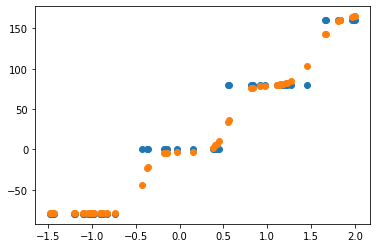

In [172]:
plt.scatter(x_test, y_test)
plt.scatter(x_test, pred)

In [173]:
print("MAE na zbiorze: \ntreningowym: ", metrics.mean_absolute_error(y, mlp.forward(x)),
     "\ntestowym: ", metrics.mean_absolute_error(y_test, mlp.forward(x_test)))

MAE na zbiorze: 
treningowym:  5.968120948200472 
testowym:  6.825516554456828


Sieć bardzo przyzwoicie przybliża zbiór testowy.

### Zbiór multimodal-large

In [174]:
train_df = pd.read_csv('mio_data/regression/multimodal-large-training.csv', index_col=0)
test_df = pd.read_csv('mio_data/regression/multimodal-large-test.csv', index_col=0)

x = np.asarray(train_df['x']).reshape(-1, 1)
y = np.asarray(train_df['y']).reshape(-1, 1)

x_test = np.asarray(test_df['x']).reshape(-1,1)
y_test = np.asarray(test_df['y']).reshape(-1, 1)

In [175]:
layers = [1,10,1]
mlp = MLP(
        layers = layers, 
        weights_biases = "Random",
        activation_function = "sigmoid", 
        softmax_method = False)

In [177]:
mlp.learn(x, y, batch_size=100, iterations=1000, alpha=0.001, method = "Classic")
pred = mlp.forward(x_test)

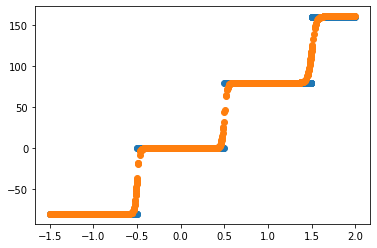

In [178]:
plt.scatter(x_test, y_test)
plt.scatter(x_test, pred)

In [179]:
print("MAE na zbiorze: \ntreningowym: ", metrics.mean_absolute_error(y, mlp.forward(x)),
     "\ntestowym: ", metrics.mean_absolute_error(y_test, mlp.forward(x_test)))

MAE na zbiorze: 
treningowym:  1.7589022962097847 
testowym:  2.0583202956981896


Podobnie jak w przypadku poprzedniego zbioru.

### Porównanie metod inicjalizacji wag (U[0,1] vs Xavier)

Testowanie - 100 powtórzeń

In [185]:
unifrom_results = []
xavier_results = []

for _ in range (100):
    mlp_uniform = MLP(
        layers = layers, 
        weights_biases = "Random",
        activation_function = "sigmoid", 
        softmax_method = False)
    mlp_uniform.learn(x, y, batch_size=100, iterations=300, alpha=0.001, method = "Classic")
    unifrom_results.append(metrics.mean_absolute_error(y_test, mlp_uniform.forward(x_test)))
    
    mlp_xavier = MLP(
        layers = layers, 
        weights_biases = "Xavier",
        activation_function = "sigmoid", 
        softmax_method = False)
    mlp_xavier.learn(x, y, batch_size=100, iterations=300, alpha=0.001, method = "Classic")
    pred_xavier = mlp_xavier.forward(x_test)
    xavier_results.append(metrics.mean_absolute_error(y_test, mlp_xavier.forward(x_test)))
    

In [192]:
print("Średni wynik wag U[0,1]: ", np.mean(unifrom_results),
     "\nŚredni wynik Xavier: ", np.mean(xavier_results),)

Średni wynik wag U[0,1]:  6.183161565384997 
Średni wynik Xavier:  5.889542135106558


Jak widzimy, modele które wagi mają losowane metodą Xavier radzą sobie średnio lepiej od tych których wagi początkowe pochodzą z rozkładu U[0,1]

### Podsumowanie PD2 

Druga praca domowa pomogła zrozumieć ideę propagacji wstecznej błędu. Mogłem zaobserwować, że w znacznym stopniu ułatwia to korzystanie z sieci neuronowych w praktyce. Jednocześnie widać, że jest jeszcze spore pole do poprawy. Dodatkowo, przeprowadzony test potwierdził, że wagi początkowe ustalane metodą Xavier są dużo efektywniejsze od wag z U[0,1] 

## Tydzień 3 - Implementacja momentu i normalizacji gradientu

Trzeci tydzień zajęć polegał na zaimplementowaniu metod poprawiających uczenie gradientowe - moment i normalizację. 
Eksperymenty przeprowadziłem na zbiorach:

    square-large,
    steps-large,
    multimodal-large.


In [88]:
iterations_set = [5, 10, 20, 75, 100, 150, 200,500]
layers=[1, 10, 1]

### Zbiór Steps Large

Testowanie dla zbioru różnych liczb iteracji

In [94]:
train_df = pd.read_csv('mio_data/regression/steps-large-training.csv', index_col=0)
test_df = pd.read_csv('mio_data/regression/steps-large-test.csv', index_col=0)

x = np.asarray(train_df['x']).reshape(-1, 1)
y = np.asarray(train_df['y']).reshape(-1, 1)
x_test = np.asarray(test_df['x']).reshape(-1,1)
y_test = np.asarray(test_df['y']).reshape(-1, 1)

results_classic = []
results_momentum = []
results_rmsprop = []

for iterations in iterations_set:
    for _ in range (2):
        results_classic_temp = []
        results_momentum_temp = []
        results_rmsprop_temp = []

        mlp_classic = MLP(
        layers = layers, 
        weights_biases = "Random",
        activation_function = sigmoid,
        activation_function_der = sigmoid_der)

        mlp_classic.learn(x, y, iterations=iterations, batch_size = 20, alpha=0.01, method = "Classic")
        results_classic_temp.append(mean_absolute_error(y_test, mlp_classic.forward(x_test)))

        mlp_momentum = MLP(
        layers = layers, 
        weights_biases = "Random",
        activation_function = sigmoid,
        activation_function_der = sigmoid_der)

        mlp_momentum.learn(x, y, iterations=iterations, batch_size = 20, alpha=0.05, var=0.5, method = "Momentum")
        results_momentum_temp.append(mean_absolute_error(y_test, mlp_momentum.forward(x_test)))

        mlp_rmsprop = MLP(
        layers = layers, 
        weights_biases = "Random",
        activation_function = sigmoid,
        activation_function_der = sigmoid_der)

        mlp_rmsprop.learn(x, y, iterations=iterations, batch_size = 20, alpha=0.05, var=0.9, method = "RMSProp")
        results_rmsprop_temp.append(mean_absolute_error(y_test, mlp_rmsprop.forward(x_test)))
    
    results_classic.append(np.mean(results_classic_temp))
    results_momentum.append(np.mean(results_momentum_temp))
    results_rmsprop.append(np.mean(results_rmsprop_temp))

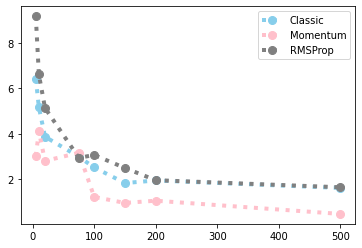

In [95]:
df=pd.DataFrame({'x_values': iterations_set, 'Classic': results_classic, 'Momentum': results_momentum, 'RMSProp': results_rmsprop })
plt.plot( 'x_values', 'Classic', data=df, marker='o', markerfacecolor='skyblue', markersize=8, color='skyblue', linewidth=4, linestyle='dotted')
plt.plot( 'x_values', 'Momentum', data=df, marker='o', markerfacecolor='pink', markersize=8, color='pink', linewidth=4, linestyle='dotted')
plt.plot( 'x_values', 'RMSProp', data=df, marker='o', markerfacecolor='grey', markersize=8, color='grey', linewidth=4, linestyle='dotted')
plt.legend()

Widzimy, że najszybciej zbiega Momentum, a RMSProp i klasyczna propagacja wsteczna radzą sobie podobnie

### Zbiór Square Large

Testowanie dla zbioru różnych liczb iteracji

In [110]:
train_df = pd.read_csv('mio_data/regression/square-large-training.csv', index_col=0)
test_df = pd.read_csv('mio_data/regression/square-large-test.csv', index_col=0)

x = np.asarray(train_df['x']).reshape(-1, 1)
y = np.asarray(train_df['y']).reshape(-1, 1)
x_test = np.asarray(test_df['x']).reshape(-1,1)
y_test = np.asarray(test_df['y']).reshape(-1, 1)

results_classic = []
results_momentum = []
results_rmsprop = []

for iterations in iterations_set:
    for _ in range (2):
        results_classic_temp = []
        results_momentum_temp = []
        results_rmsprop_temp = []

        mlp_classic = MLP(
        layers = layers, 
        weights_biases = "Random",
        activation_function = sigmoid,
        activation_function_der = sigmoid_der)

        mlp_classic.learn(x, y, iterations=iterations, batch_size = 20, alpha=0.001, method = "Classic")
        results_classic_temp.append(mean_absolute_error(y_test, mlp_classic.forward(x_test)))

        mlp_momentum = MLP(
        layers = layers, 
        weights_biases = "Random",
        activation_function = sigmoid,
        activation_function_der = sigmoid_der)

        mlp_momentum.learn(x, y, iterations=iterations, batch_size = 20, alpha=0.01, var=0.2, method = "Momentum")
        results_momentum_temp.append(mean_absolute_error(y_test, mlp_momentum.forward(x_test)))

        mlp_rmsprop = MLP(
        layers = layers, 
        weights_biases = "Random",
        activation_function = sigmoid,
        activation_function_der = sigmoid_der)

        mlp_rmsprop.learn(x, y, iterations=iterations, batch_size = 20, alpha=0.01, var=0.75, method = "RMSProp")
        results_rmsprop_temp.append(mean_absolute_error(y_test, mlp_rmsprop.forward(x_test)))
    
    results_classic.append(np.mean(results_classic_temp))
    results_momentum.append(np.mean(results_momentum_temp))
    results_rmsprop.append(np.mean(results_rmsprop_temp))

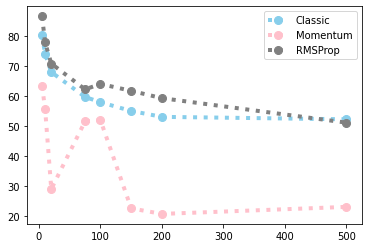

In [112]:
df=pd.DataFrame({'x_values': iterations_set, 'Classic': results_classic, 'Momentum': results_momentum, 'RMSProp': results_rmsprop })
plt.plot( 'x_values', 'Classic', data=df, marker='o', markerfacecolor='skyblue', markersize=8, color='skyblue', linewidth=4, linestyle='dotted')
plt.plot( 'x_values', 'Momentum', data=df, marker='o', markerfacecolor='pink', markersize=8, color='pink', linewidth=4, linestyle='dotted')
plt.plot( 'x_values', 'RMSProp', data=df, marker='o', markerfacecolor='grey', markersize=8, color='grey', linewidth=4, linestyle='dotted')
plt.legend()

Wnioski jak w zbiorze pierwszym, możemy zobaczyć, że Momentum poradziło sobie najlepiej, mimo że około 100 iteracji trochę "zbłądziło".

### Zbiór Multimodal Large

Testowanie dla zbioru różnych liczb iteracji

In [114]:
train_df = pd.read_csv('mio_data/regression/multimodal-large-training.csv', index_col=0)
test_df = pd.read_csv('mio_data/regression/multimodal-large-test.csv', index_col=0)

x = np.asarray(train_df['x']).reshape(-1, 1)
y = np.asarray(train_df['y']).reshape(-1, 1)
x_test = np.asarray(test_df['x']).reshape(-1,1)
y_test = np.asarray(test_df['y']).reshape(-1, 1)

results_classic = []
results_momentum = []
results_rmsprop = []

for iterations in iterations_set:
    for _ in range (2):
        results_classic_temp = []
        results_momentum_temp = []
        results_rmsprop_temp = []

        mlp_classic = MLP(
        layers = layers, 
        weights_biases = "Random",
        activation_function = sigmoid,
        activation_function_der = sigmoid_der)

        mlp_classic.learn(x, y, iterations=iterations, batch_size = 20, alpha=0.001, method = "Classic")
        results_classic_temp.append(mean_absolute_error(y_test, mlp_classic.forward(x_test)))

        mlp_momentum = MLP(
        layers = layers, 
        weights_biases = "Random",
        activation_function = sigmoid,
        activation_function_der = sigmoid_der)

        mlp_momentum.learn(x, y, iterations=iterations, batch_size = 20, alpha=0.01, var=0.8, method = "Momentum")
        results_momentum_temp.append(mean_absolute_error(y_test, mlp_momentum.forward(x_test)))

        mlp_rmsprop = MLP(
        layers = layers, 
        weights_biases = "Random",
        activation_function = sigmoid,
        activation_function_der = sigmoid_der)

        mlp_rmsprop.learn(x, y, iterations=iterations, batch_size = 20, alpha=0.01, var=0.7, method = "RMSProp")
        results_rmsprop_temp.append(mean_absolute_error(y_test, mlp_rmsprop.forward(x_test)))
    
    results_classic.append(np.mean(results_classic_temp))
    results_momentum.append(np.mean(results_momentum_temp))
    results_rmsprop.append(np.mean(results_rmsprop_temp))

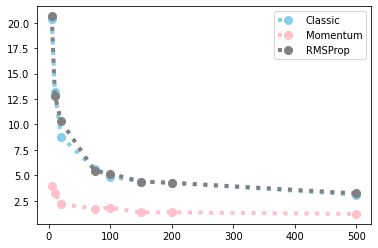

In [115]:
df=pd.DataFrame({'x_values': iterations_set, 'Classic': results_classic, 'Momentum': results_momentum, 'RMSProp': results_rmsprop })
plt.plot( 'x_values', 'Classic', data=df, marker='o', markerfacecolor='skyblue', markersize=8, color='skyblue', linewidth=4, linestyle='dotted')
plt.plot( 'x_values', 'Momentum', data=df, marker='o', markerfacecolor='pink', markersize=8, color='pink', linewidth=4, linestyle='dotted')
plt.plot( 'x_values', 'RMSProp', data=df, marker='o', markerfacecolor='grey', markersize=8, color='grey', linewidth=4, linestyle='dotted')
plt.legend()

### Podsumowanie PD3

Trzeci praca domowa pozwoliła mi lepiej zrozumieć działanie algorytmów uprawniających uczenie gradientowe. Z przeprowadzonych testów okazało się, że metoda Momentu zdecydowanie poprawia osiągi sieci, natomiast RMSProp wypada podobnie jak domyślne uczenie gradientowe. Warto jednak pamiętać, że struktura sieci i hiperparametry uczenia były ustawiane ręcznie, co mogło zaciemnić obraz eksperymentu.

## Tydzień 4. - Rozwiązywanie zadania klasyfikacji

Praca domowa nr 4 polegała na zaimplementowaniu zmiany w algorytmie, która pozwoliła by rozwiązywać zadania klasyfikacji (dotychczas rozważaliśmy jedynie regresję). Dodatkowo należało dodać opcję pozwalającą używać funkcji Softmax na ostatniej warswie, co wiązało się z istotną zmianą w pochodnej. 

## Rings3 regular

In [4]:
train_df = pd.read_csv('mio_data/classification/rings3-regular-training.csv')
test_df = pd.read_csv('mio_data/classification/rings3-regular-test.csv')

x = np.asarray(train_df[['x', 'y']])
x_test = np.asarray(test_df[['x', 'y']])
c = np.asarray(train_df['c']).reshape(-1, 1)
c_test = np.asarray(test_df['c']).reshape(-1, 1)

encoded = to_categorical(c)

In [5]:
layers = [2, 64, 64, 3]
mlp = MLP(layers = layers, weights_biases = "Random", 
          activation_function = "sigmoid", softmax_method = False)

mlp.learn(x = x, y = encoded, alpha = 0.01, iterations = 1000)

mlp_softmax = MLP(layers = layers, weights_biases = "Random", 
          activation_function = "sigmoid", softmax_method = True)

mlp_softmax.learn(x = x, y = encoded, alpha = 0.01, iterations = 1000)

Text(0.5, 1.0, 'Softmax')

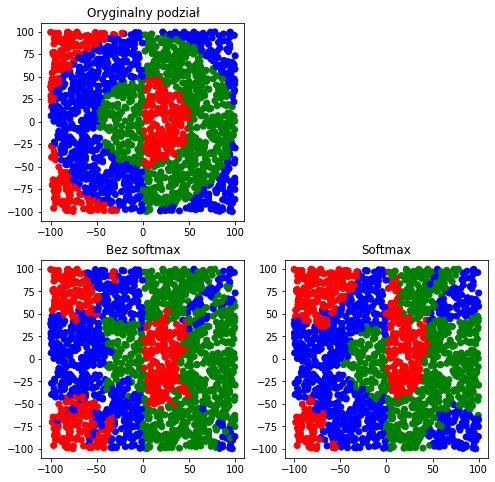

In [68]:
colors = ['red','green','blue']

fig = plt.figure(figsize=(8,8))

plt.subplot(2, 2, 1)
plt.scatter(test_df['x'], test_df['y'], c=test_df['c'], cmap=matplotlib.colors.ListedColormap(colors))
plt.title('Oryginalny podział')

plt.subplot(2, 2, 3)
plt.scatter(test_df['x'], test_df['y'], c= mlp.classify(x_test), cmap=matplotlib.colors.ListedColormap(colors))
plt.title('Bez softmax')

plt.subplot(2, 2, 4)
plt.scatter(test_df['x'], test_df['y'], c= mlp_softmax.classify(x_test), cmap=matplotlib.colors.ListedColormap(colors))
plt.title('Softmax')


In [7]:
print("Softmax:",accuracy_score(test_df['c'], mlp_softmax.classify(x_test)),
"\nBez softmax:",accuracy_score(test_df['c'], mlp.classify(x_test)))

Softmax: 0.598 
Bez softmax: 0.552


Funkcja z softmaxem poradziła sobie lepiej, a patrząc na trudność zbioru, to całkiem dobrze.

In [30]:
results_softmax = []
results_def = []

for iterations in iterations_set:
    for _ in range (2):
        results_softmax_temp = []
        results_def_temp = []

        mlp_softmax = MLP(layers = layers, weights_biases = "Random", 
          activation_function = "sigmoid", softmax_method = True)

        mlp_softmax.learn(x = x, y = encoded, alpha = 0.01, iterations = iterations)
        results_softmax_temp.append(accuracy_score(test_df['c'], mlp_softmax.classify(x_test)))

        mlp = MLP(layers = layers, weights_biases = "Random", 
          activation_function = "sigmoid", softmax_method = False)

        mlp.learn(x = x, y = encoded, alpha = 0.01, iterations = iterations)
        results_def_temp.append(accuracy_score(test_df['c'], mlp.classify(x_test)))

    results_softmax.append(np.mean(results_softmax_temp))
    results_def.append(np.mean(results_def_temp))


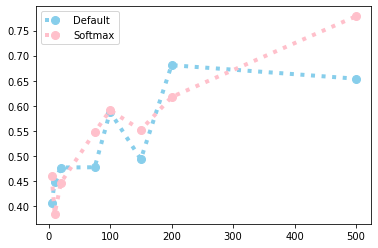

In [31]:
df=pd.DataFrame({'x_values': iterations_set, 'Default': results_def, 'Softmax': results_softmax})
plt.plot( 'x_values', 'Default', data=df, marker='o', markerfacecolor='skyblue', markersize=8, color='skyblue', linewidth=4, linestyle='dotted')
plt.plot( 'x_values', 'Softmax', data=df, marker='o', markerfacecolor='pink', markersize=8, color='pink', linewidth=4, linestyle='dotted')
plt.legend()

Jak widać na wykresie, funkcja softmax powoduje lepszą zbieżność.

## Xor3 

In [70]:
train_df = pd.read_csv('mio_data/classification/xor3-training.csv')
test_df = pd.read_csv('mio_data/classification/xor3-test.csv')

x = np.asarray(train_df[['x', 'y']])
x_test = np.asarray(test_df[['x', 'y']])
c = np.asarray(train_df['c']).reshape(-1, 1)
c_test = np.asarray(test_df['c']).reshape(-1, 1)

encoded = to_categorical(c)

In [71]:
layers = [2, 20, 2]
mlp = MLP(layers = layers, weights_biases = "Random", 
          activation_function = "sigmoid", softmax_method = False)

mlp.learn(x = x, y = encoded, alpha = 0.01, iterations = 3000, method = "Momentum", var =0.5)

mlp_softmax = MLP(layers = layers, weights_biases = "Random", 
          activation_function = "sigmoid", softmax_method = True)

mlp_softmax.learn(x = x, y = encoded, alpha = 0.01, iterations = 3000, method = "Momentum", var =0.5)

Text(0.5, 1.0, 'Softmax')

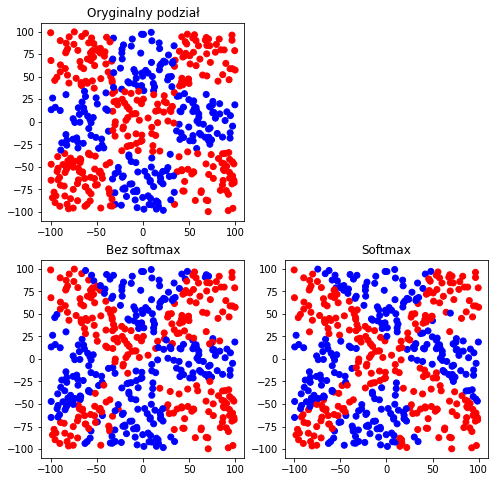

In [72]:
colors = ['red','green','blue']

fig = plt.figure(figsize=(8,8))

plt.subplot(2, 2, 1)
plt.scatter(test_df['x'], test_df['y'], c=test_df['c'], cmap=matplotlib.colors.ListedColormap(colors))
plt.title('Oryginalny podział')

plt.subplot(2, 2, 3)
plt.scatter(test_df['x'], test_df['y'], c= mlp.classify(x_test), cmap=matplotlib.colors.ListedColormap(colors))
plt.title('Bez softmax')

plt.subplot(2, 2, 4)
plt.scatter(test_df['x'], test_df['y'], c= mlp_softmax.classify(x_test), cmap=matplotlib.colors.ListedColormap(colors))
plt.title('Softmax')

In [73]:
print("Softmax:",accuracy_score(test_df['c'], mlp_softmax.classify(x_test)),
"\nBez softmax:",accuracy_score(test_df['c'], mlp.classify(x_test)))

Softmax: 0.778 
Bez softmax: 0.768


Zbiór dużo łatwiejszy, oba modele poradziły sobie w zadawalającym stopniu.

In [38]:
results_softmax = []
results_def = []

for iterations in iterations_set:
    for _ in range (2):
        results_softmax_temp = []
        results_def_temp = []

        mlp_softmax = MLP(layers = layers, weights_biases = "Random", 
          activation_function = "sigmoid", softmax_method = True)

        mlp_softmax.learn(x = x, y = encoded, alpha = 0.01, iterations = iterations)
        results_softmax_temp.append(accuracy_score(test_df['c'], mlp_softmax.classify(x_test)))

        mlp = MLP(layers = layers, weights_biases = "Random", 
          activation_function = "sigmoid", softmax_method = False)

        mlp.learn(x = x, y = encoded, alpha = 0.01, iterations = iterations)
        results_def_temp.append(accuracy_score(test_df['c'], mlp.classify(x_test)))

    results_softmax.append(np.mean(results_softmax_temp))
    results_def.append(np.mean(results_def_temp))


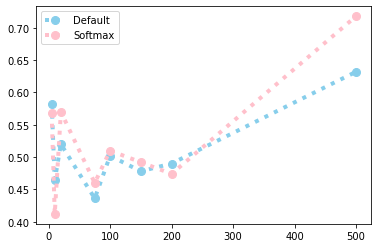

In [39]:
df=pd.DataFrame({'x_values': iterations_set, 'Default': results_def, 'Softmax': results_softmax})
plt.plot( 'x_values', 'Default', data=df, marker='o', markerfacecolor='skyblue', markersize=8, color='skyblue', linewidth=4, linestyle='dotted')
plt.plot( 'x_values', 'Softmax', data=df, marker='o', markerfacecolor='pink', markersize=8, color='pink', linewidth=4, linestyle='dotted')
plt.legend()

Zbieżność bardzo podobna w tym przypadku, jedynie widać, że przy dużej liczbie iteracji (500) softmax odskoczył domyślnej funkcji.

## Easy

In [74]:
train_df = pd.read_csv('mio_data/classification/easy-training.csv')
test_df = pd.read_csv('mio_data/classification/easy-test.csv')

x = np.asarray(train_df[['x', 'y']])
x_test = np.asarray(test_df[['x', 'y']])
c = np.asarray(train_df['c']).reshape(-1, 1)
c_test = np.asarray(test_df['c']).reshape(-1, 1)

encoded = to_categorical(c)

In [75]:
layers = [2, 20, 2]
mlp = MLP(layers = layers, weights_biases = "Random", 
          activation_function = "sigmoid", softmax_method = False)

mlp.learn(x = x, y = encoded, alpha = 0.01, iterations = 100, method = "Momentum", var =0.5)

mlp_softmax = MLP(layers = layers, weights_biases = "Random", 
          activation_function = "sigmoid", softmax_method = True)

mlp_softmax.learn(x = x, y = encoded, alpha = 0.01, iterations = 100, method = "Momentum", var =0.5)

Text(0.5, 1.0, 'Softmax')

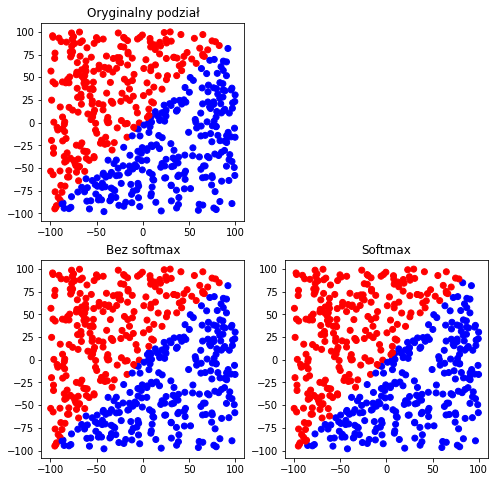

In [76]:
colors = ['red','green','blue']

fig = plt.figure(figsize=(8,8))

plt.subplot(2, 2, 1)
plt.scatter(test_df['x'], test_df['y'], c=test_df['c'], cmap=matplotlib.colors.ListedColormap(colors))
plt.title('Oryginalny podział')

plt.subplot(2, 2, 3)
plt.scatter(test_df['x'], test_df['y'], c= mlp.classify(x_test), cmap=matplotlib.colors.ListedColormap(colors))
plt.title('Bez softmax')

plt.subplot(2, 2, 4)
plt.scatter(test_df['x'], test_df['y'], c= mlp_softmax.classify(x_test), cmap=matplotlib.colors.ListedColormap(colors))
plt.title('Softmax')

In [77]:
print(accuracy_score(test_df['c'], mlp_softmax.classify(x_test)),
accuracy_score(test_df['c'], mlp.classify(x_test)))

0.992 0.996


Jak widać zbiór jest bardzo łatwy, więc oba modele poradziły sobie bardzo dobrze.

In [44]:
results_softmax = []
results_def = []

for iterations in iterations_set:
    for _ in range (2):
        results_softmax_temp = []
        results_def_temp = []

        mlp_softmax = MLP(layers = layers, weights_biases = "Random", 
          activation_function = "sigmoid", softmax_method = True)

        mlp_softmax.learn(x = x, y = encoded, alpha = 0.01, iterations = iterations)
        results_softmax_temp.append(accuracy_score(test_df['c'], mlp_softmax.classify(x_test)))

        mlp = MLP(layers = layers, weights_biases = "Random", 
          activation_function = "sigmoid", softmax_method = False)

        mlp.learn(x = x, y = encoded, alpha = 0.01, iterations = iterations)
        results_def_temp.append(accuracy_score(test_df['c'], mlp.classify(x_test)))

    results_softmax.append(np.mean(results_softmax_temp))
    results_def.append(np.mean(results_def_temp))


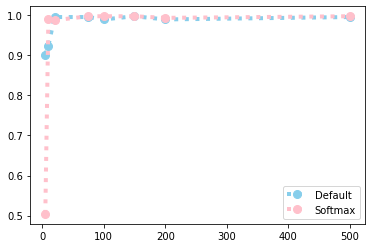

In [45]:
df=pd.DataFrame({'x_values': iterations_set, 'Default': results_def, 'Softmax': results_softmax})
plt.plot( 'x_values', 'Default', data=df, marker='o', markerfacecolor='skyblue', markersize=8, color='skyblue', linewidth=4, linestyle='dotted')
plt.plot( 'x_values', 'Softmax', data=df, marker='o', markerfacecolor='pink', markersize=8, color='pink', linewidth=4, linestyle='dotted')
plt.legend()

Zbiór jest tak łatwy (jak wskazuje jego nazwa ;)) że nie da się porównać sieci.

### Podsumowanie PD4

Pisanie tej pracy domowej pozwoliło zapoznać się z pochodną softmaxa, która znacznie różni się od pozostałych funkcji, co wynika z postaci softmaxa. Przeprowadzone eksperymenty pokazały, że była to wartościowa praca, ponieważ softmax pozwala osiągać lepsze rezultaty.

## Tydzień 5. - Testowanie różnych funkcji aktywacji

Piąty tydzień przyniósł zmianę funkcji aktywacji. Na szczęście nie miałem zahardcodowanego softmaxa, więc zmiana nie była zbyt trudna. Dodałem funkcje: relu, liniową i tanh.

Testy przeprowadziłem na zbiorach:

    regresja
        steps-large,
        multimodal-large
    klasyfikacja
        rings5-regular
        rings3-regular



## Steps large

In [39]:
train_df = pd.read_csv('mio_data/regression/steps-large-training.csv')
test_df = pd.read_csv('mio_data/regression/steps-large-test.csv')

normalized_train_df=(train_df-train_df.mean())/train_df.std()

x = np.asarray(train_df['x']).reshape(-1, 1)
y = np.asarray(train_df['y']).reshape(-1, 1)

x_normalized = np.asarray((train_df['x']-train_df['x'].mean())/train_df['x'].std()).reshape(-1, 1)
y_normalized = np.asarray((train_df['y']-train_df['y'].mean())/train_df['y'].std()).reshape(-1, 1)

x_test = np.asarray(test_df['x']).reshape(-1,1)
y_test = np.asarray(test_df['y']).reshape(-1, 1)

x_normalized_test = np.asarray((test_df['x']-test_df['x'].mean())/test_df['x'].std()).reshape(-1, 1)
y_normalized_test = np.asarray((test_df['y']-test_df['y'].mean())/test_df['y'].std()).reshape(-1, 1)


In [40]:
iterations_set = [1,5,10,25,50]

In [41]:
layers = [1, 10, 1]

results_sigmoid = []
results_relu = []
results_linear = []
results_tanh = []

for iterations in iterations_set:
    for _ in range (2):
        results_sigmoid_temp = []
        results_relu_temp = []
        results_linear_temp = []
        results_tanh_temp = []
        
        mlp_sigmoid = MLP(
        layers = layers, 
        weights_biases = "Random",
        activation_function = "sigmoid", 
        softmax_method = False)

        mlp_sigmoid.learn(x_normalized, y_normalized, iterations=iterations, batch_size = 20, 
                          alpha=0.01, method = "Momentum", var=0.99)
        results_sigmoid_temp.append(mean_absolute_error(y_normalized_test, 
                                                        mlp_sigmoid.forward(x_normalized_test)))

        mlp_relu = MLP(
        layers = layers, 
        weights_biases = "Random",
        activation_function = "relu", 
        softmax_method = False)

        mlp_relu.learn(x_normalized, y_normalized, iterations=iterations, batch_size = 20, 
                       alpha=0.01, var=0.8, method = "Momentum")
        results_relu_temp.append(mean_absolute_error(y_normalized_test, 
                                                     mlp_relu.forward(x_normalized_test)))

        mlp_linear = MLP(
        layers = layers, 
        weights_biases = "Random",
        activation_function = "linear", 
        softmax_method = False)

        mlp_linear.learn(x_normalized, y_normalized, iterations=iterations, batch_size = 20, 
                         alpha=0.01, var=0.5, method = "Momentum")
        results_linear_temp.append(mean_absolute_error(y_normalized_test, 
                                                       mlp_linear.forward(x_normalized_test)))
        
        mlp_tanh = MLP(
        layers = layers, 
        weights_biases = "Random",
        activation_function = "tanh", 
        softmax_method = False)

        mlp_tanh.learn(x_normalized, y_normalized, iterations=iterations, 
                       batch_size = 20, alpha=0.1, var=0.9, method = "Momentum")
        results_tanh_temp.append(mean_absolute_error(y_normalized_test, 
                                                     mlp_tanh.forward(x_normalized_test)))
    
    results_sigmoid.append(np.mean(results_sigmoid_temp))
    results_relu.append(np.mean(results_relu_temp))
    results_linear.append(np.mean(results_linear_temp))
    results_tanh.append(np.mean(results_tanh_temp))

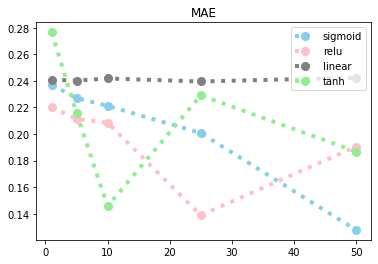

In [42]:
df=pd.DataFrame({'x_values': iterations_set, 'sigmoid': results_sigmoid,
                                             'relu': results_relu, 
                                             'linear': results_linear, 
                                             'tanh': results_tanh})
plt.plot( 'x_values', 'sigmoid', data=df, marker='o', markerfacecolor='skyblue', markersize=8, color='skyblue', linewidth=4, linestyle='dotted')
plt.plot( 'x_values', 'relu', data=df, marker='o', markerfacecolor='pink', markersize=8, color='pink', linewidth=4, linestyle='dotted')
plt.plot( 'x_values', 'linear', data=df, marker='o', markerfacecolor='grey', markersize=8, color='grey', linewidth=4, linestyle='dotted')
plt.plot( 'x_values', 'tanh', data=df, marker='o', markerfacecolor='lightgreen', markersize=8, color='lightgreen', linewidth=4, linestyle='dotted')

plt.title("MAE")
plt.legend()

Jak widać, najlepiej poradził sobie sigmoid. Tanh i relu trochę się "pogubiły" ale ostatniecznie osiągnęły podobne rezultaty. Funkcja liniowa wcale nie zbiega.

## Multimodal large

In [45]:
train_df = pd.read_csv('mio_data/regression/multimodal-large-training.csv')
test_df = pd.read_csv('mio_data/regression/multimodal-large-test.csv')

normalized_train_df=(train_df-train_df.mean())/train_df.std()

x = np.asarray(train_df['x']).reshape(-1, 1)
y = np.asarray(train_df['y']).reshape(-1, 1)

x_normalized = np.asarray((train_df['x']-train_df['x'].mean())/train_df['x'].std()).reshape(-1, 1)
y_normalized = np.asarray((train_df['y']-train_df['y'].mean())/train_df['y'].std()).reshape(-1, 1)

x_test = np.asarray(test_df['x']).reshape(-1,1)
y_test = np.asarray(test_df['y']).reshape(-1, 1)

x_normalized_test = np.asarray((test_df['x']-test_df['x'].mean())/test_df['x'].std()).reshape(-1, 1)
y_normalized_test = np.asarray((test_df['y']-test_df['y'].mean())/test_df['y'].std()).reshape(-1, 1)


In [46]:
iterations_set = [1,5,10,25,50]

In [47]:
layers = [1, 32, 1]

results_sigmoid = []
results_relu = []
results_linear = []
results_tanh = []

for iterations in iterations_set:
    for _ in range (2):
        results_sigmoid_temp = []
        results_relu_temp = []
        results_linear_temp = []
        results_tanh_temp = []
        
        mlp_sigmoid = MLP(
        layers = layers, 
        weights_biases = "Random",
        activation_function = "sigmoid", 
        softmax_method = False)

        mlp_sigmoid.learn(x_normalized, y_normalized, iterations=iterations, batch_size = 20, 
                          alpha=0.01, method = "Momentum", var=0.99)
        results_sigmoid_temp.append(mean_absolute_error(y_normalized_test, 
                                                        mlp_sigmoid.forward(x_normalized_test)))

        mlp_relu = MLP(
        layers = layers, 
        weights_biases = "Random",
        activation_function = "relu", 
        softmax_method = False)

        mlp_relu.learn(x_normalized, y_normalized, iterations=iterations, batch_size = 20, 
                       alpha=0.01, var=0.8, method = "Momentum")
        results_relu_temp.append(mean_absolute_error(y_normalized_test, 
                                                     mlp_relu.forward(x_normalized_test)))

        mlp_linear = MLP(
        layers = layers, 
        weights_biases = "Random",
        activation_function = "linear", 
        softmax_method = False)

        mlp_linear.learn(x_normalized, y_normalized, iterations=iterations, batch_size = 20, 
                         alpha=0.01, var=0.5, method = "Momentum")
        results_linear_temp.append(mean_absolute_error(y_normalized_test, 
                                                       mlp_linear.forward(x_normalized_test)))
        
        mlp_tanh = MLP(
        layers = layers, 
        weights_biases = "Random",
        activation_function = "tanh", 
        softmax_method = False)

        mlp_tanh.learn(x_normalized, y_normalized, iterations=iterations, 
                       batch_size = 20, alpha=0.1, var=0.9, method = "Momentum")
        results_tanh_temp.append(mean_absolute_error(y_normalized_test, 
                                                     mlp_tanh.forward(x_normalized_test)))
    
    results_sigmoid.append(np.mean(results_sigmoid_temp))
    results_relu.append(np.mean(results_relu_temp))
    results_linear.append(np.mean(results_linear_temp))
    results_tanh.append(np.mean(results_tanh_temp))

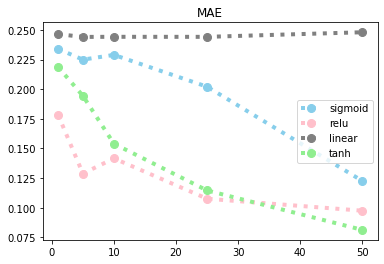

In [48]:
df=pd.DataFrame({'x_values': iterations_set, 'sigmoid': results_sigmoid,
                                             'relu': results_relu, 
                                             'linear': results_linear, 
                                             'tanh': results_tanh})
plt.plot( 'x_values', 'sigmoid', data=df, marker='o', markerfacecolor='skyblue', markersize=8, color='skyblue', linewidth=4, linestyle='dotted')
plt.plot( 'x_values', 'relu', data=df, marker='o', markerfacecolor='pink', markersize=8, color='pink', linewidth=4, linestyle='dotted')
plt.plot( 'x_values', 'linear', data=df, marker='o', markerfacecolor='grey', markersize=8, color='grey', linewidth=4, linestyle='dotted')
plt.plot( 'x_values', 'tanh', data=df, marker='o', markerfacecolor='lightgreen', markersize=8, color='lightgreen', linewidth=4, linestyle='dotted')

plt.title("MAE")
plt.legend()

Relu i tanh poradziły sobie podobnie, sigmoid trochę gorzej. Funkcja liniowa zdecydowanie nie dała sobie rady 

## Rings5 

In [49]:
train_df = pd.read_csv('mio_data/classification/rings5-regular-training.csv')
test_df = pd.read_csv('mio_data/classification/rings5-regular-test.csv')

normalized_train_df=(train_df-train_df.mean())/train_df.std()
normalized_test_df=(test_df-test_df.mean())/test_df.std()


x = np.asarray(normalized_train_df[['x', 'y']])
x_test = np.asarray(normalized_test_df[['x', 'y']])
c = np.asarray(train_df['c']).reshape(-1, 1)
c_test = np.asarray(test_df['c']).reshape(-1, 1)

encoded = to_categorical(c)

In [51]:
iterations_set = [1,5,10,25,50,100]

In [52]:
layers = [2, 20,20, 5]

results_sigmoid = []
results_relu = []
results_linear = []
results_tanh = []

for iterations in iterations_set:
    for _ in range (2):
        results_sigmoid_temp = []
        results_relu_temp = []
        results_linear_temp = []
        results_tanh_temp = []
        
        mlp_sigmoid = MLP(
        layers = layers, 
        weights_biases = "Random",
        activation_function = "sigmoid", 
        softmax_method = True)

        mlp_sigmoid.learn(x, encoded, iterations=iterations, batch_size = 20, 
                          alpha=0.1, method = "Momentum", var=0.8)
        results_sigmoid_temp.append(accuracy_score(c_test, mlp_sigmoid.classify(x_test)))

        mlp_relu = MLP(
        layers = layers, 
        weights_biases = "Random",
        activation_function = "relu", 
        softmax_method = True)

        mlp_relu.learn(x, encoded, iterations=iterations, batch_size = 20, 
                       alpha=0.01, var=0.8, method = "Momentum")
        results_relu_temp.append(accuracy_score(c_test, mlp_relu.classify(x_test)))

        mlp_linear = MLP(
        layers = layers, 
        weights_biases = "Random",
        activation_function = "linear", 
        softmax_method = True)

        mlp_linear.learn(x, encoded, iterations=iterations, batch_size = 20, 
                         alpha=0.01, var=0.5, method = "Momentum")
        results_linear_temp.append(accuracy_score(c_test, mlp_linear.classify(x_test)))
        
        mlp_tanh = MLP(
        layers = layers, 
        weights_biases = "Random",
        activation_function = "tanh", 
        softmax_method = True)

        mlp_tanh.learn(x, encoded, iterations=iterations, 
                       batch_size = 20, alpha=0.1, var=0.9, method = "Momentum")
        results_tanh_temp.append(accuracy_score(c_test, mlp_tanh.classify(x_test)))
    
    results_sigmoid.append(np.mean(results_sigmoid_temp))
    results_relu.append(np.mean(results_relu_temp))
    results_linear.append(np.mean(results_linear_temp))
    results_tanh.append(np.mean(results_tanh_temp))

Text(0.5, 1.0, 'tanh')

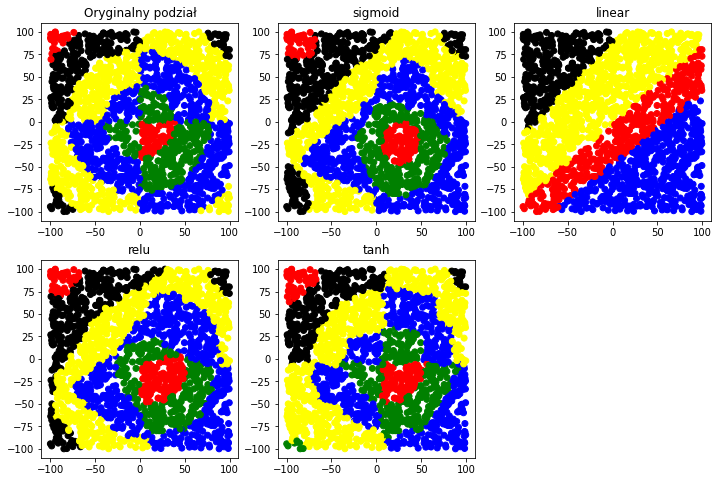

In [53]:
colors = ['red','green','blue', "yellow", "black"]

fig = plt.figure(figsize=(12,8))

plt.subplot(2, 3, 1)
plt.scatter(test_df['x'], test_df['y'], c=test_df['c'], cmap=matplotlib.colors.ListedColormap(colors))
plt.title('Oryginalny podział')

plt.subplot(2, 3, 2)
plt.scatter(test_df['x'], test_df['y'], c= mlp_sigmoid.classify(x_test), cmap=matplotlib.colors.ListedColormap(colors))
plt.title('sigmoid')

plt.subplot(2, 3, 3)
plt.scatter(test_df['x'], test_df['y'], c= mlp_linear.classify(x_test), cmap=matplotlib.colors.ListedColormap(colors))
plt.title('linear')

plt.subplot(2, 3, 4)
plt.scatter(test_df['x'], test_df['y'], c= mlp_relu.classify(x_test), cmap=matplotlib.colors.ListedColormap(colors))
plt.title('relu')

plt.subplot(2, 3, 5)
plt.scatter(test_df['x'], test_df['y'], c= mlp_tanh.classify(x_test), cmap=matplotlib.colors.ListedColormap(colors))
plt.title('tanh')



Text(0.5, 1.0, 'Accuracy')

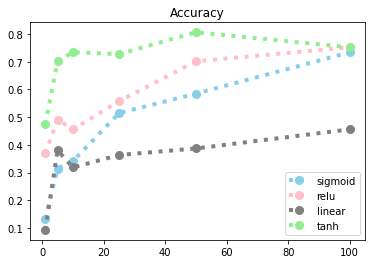

In [54]:
df=pd.DataFrame({'x_values': iterations_set, 'sigmoid': results_sigmoid,
                                             'relu': results_relu, 
                                             'linear': results_linear, 
                                             'tanh': results_tanh})
plt.plot( 'x_values', 'sigmoid', data=df, marker='o', markerfacecolor='skyblue', markersize=8, color='skyblue', linewidth=4, linestyle='dotted')
plt.plot( 'x_values', 'relu', data=df, marker='o', markerfacecolor='pink', markersize=8, color='pink', linewidth=4, linestyle='dotted')
plt.plot( 'x_values', 'linear', data=df, marker='o', markerfacecolor='grey', markersize=8, color='grey', linewidth=4, linestyle='dotted')
plt.plot( 'x_values', 'tanh', data=df, marker='o', markerfacecolor='lightgreen', markersize=8, color='lightgreen', linewidth=4, linestyle='dotted')

plt.legend()
plt.title("Accuracy")

Tanh zbiegł najszybciej,a patrząc na wykresy to najlepiej "zorientował" się na czym polega zbiór. Sigmoid i relu podobnie, natomiast funkcja liniowa znów fatalnie.

## Rings3

In [55]:
train_df = pd.read_csv('mio_data/classification/rings3-regular-training.csv')
test_df = pd.read_csv('mio_data/classification/rings3-regular-test.csv')

normalized_train_df=(train_df-train_df.mean())/train_df.std()
normalized_test_df=(test_df-test_df.mean())/test_df.std()


x = np.asarray(normalized_train_df[['x', 'y']])
x_test = np.asarray(normalized_test_df[['x', 'y']])
c = np.asarray(train_df['c']).reshape(-1, 1)
c_test = np.asarray(test_df['c']).reshape(-1, 1)

encoded = to_categorical(c)

In [56]:
iterations_set = [1,5,10,25,50,100]

In [57]:
layers = [2, 20,20,20, 3]

results_sigmoid = []
results_relu = []
results_linear = []
results_tanh = []

for iterations in iterations_set:
    for _ in range (2):
        results_sigmoid_temp = []
        results_relu_temp = []
        results_linear_temp = []
        results_tanh_temp = []
        
        mlp_sigmoid = MLP(
        layers = layers, 
        weights_biases = "Random",
        activation_function = "sigmoid", 
        softmax_method = True)

        mlp_sigmoid.learn(x, encoded, iterations=iterations, batch_size = 20, 
                          alpha=0.1, method = "Momentum", var=0.8)
        results_sigmoid_temp.append(accuracy_score(c_test, mlp_sigmoid.classify(x_test)))

        mlp_relu = MLP(
        layers = layers, 
        weights_biases = "Random",
        activation_function = "relu", 
        softmax_method = True)

        mlp_relu.learn(x, encoded, iterations=iterations, batch_size = 20, 
                       alpha=0.01, var=0.8, method = "Momentum")
        results_relu_temp.append(accuracy_score(c_test, mlp_relu.classify(x_test)))

        mlp_linear = MLP(
        layers = layers, 
        weights_biases = "Random",
        activation_function = "linear", 
        softmax_method = True)

        mlp_linear.learn(x, encoded, iterations=iterations, batch_size = 20, 
                         alpha=0.01, var=0.5, method = "Momentum")
        results_linear_temp.append(accuracy_score(c_test, mlp_linear.classify(x_test)))
        
        mlp_tanh = MLP(
        layers = layers, 
        weights_biases = "Random",
        activation_function = "tanh", 
        softmax_method = True)

        mlp_tanh.learn(x, encoded, iterations=iterations, 
                       batch_size = 20, alpha=0.1, var=0.9, method = "Momentum")
        results_tanh_temp.append(accuracy_score(c_test, mlp_tanh.classify(x_test)))
    
    results_sigmoid.append(np.mean(results_sigmoid_temp))
    results_relu.append(np.mean(results_relu_temp))
    results_linear.append(np.mean(results_linear_temp))
    results_tanh.append(np.mean(results_tanh_temp))

Text(0.5, 1.0, 'tanh')

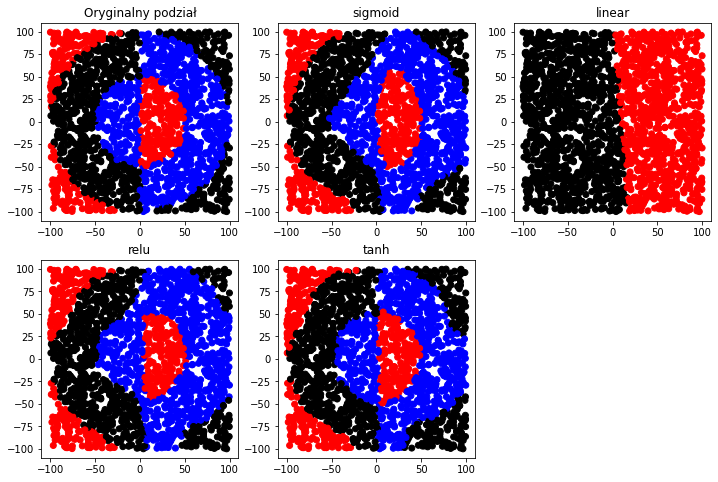

In [58]:
colors = ['red','green','blue', "yellow", "black"]

fig = plt.figure(figsize=(12,8))

plt.subplot(2, 3, 1)
plt.scatter(test_df['x'], test_df['y'], c=test_df['c'], cmap=matplotlib.colors.ListedColormap(colors))
plt.title('Oryginalny podział')

plt.subplot(2, 3, 2)
plt.scatter(test_df['x'], test_df['y'], c= mlp_sigmoid.classify(x_test), cmap=matplotlib.colors.ListedColormap(colors))
plt.title('sigmoid')

plt.subplot(2, 3, 3)
plt.scatter(test_df['x'], test_df['y'], c= mlp_linear.classify(x_test), cmap=matplotlib.colors.ListedColormap(colors))
plt.title('linear')

plt.subplot(2, 3, 4)
plt.scatter(test_df['x'], test_df['y'], c= mlp_relu.classify(x_test), cmap=matplotlib.colors.ListedColormap(colors))
plt.title('relu')

plt.subplot(2, 3, 5)
plt.scatter(test_df['x'], test_df['y'], c= mlp_tanh.classify(x_test), cmap=matplotlib.colors.ListedColormap(colors))
plt.title('tanh')



Text(0.5, 1.0, 'Accuracy')

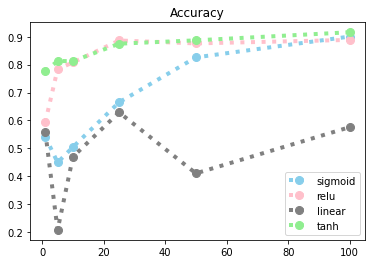

In [59]:
df=pd.DataFrame({'x_values': iterations_set, 'sigmoid': results_sigmoid,
                                             'relu': results_relu, 
                                             'linear': results_linear, 
                                             'tanh': results_tanh})
plt.plot( 'x_values', 'sigmoid', data=df, marker='o', markerfacecolor='skyblue', markersize=8, color='skyblue', linewidth=4, linestyle='dotted')
plt.plot( 'x_values', 'relu', data=df, marker='o', markerfacecolor='pink', markersize=8, color='pink', linewidth=4, linestyle='dotted')
plt.plot( 'x_values', 'linear', data=df, marker='o', markerfacecolor='grey', markersize=8, color='grey', linewidth=4, linestyle='dotted')
plt.plot( 'x_values', 'tanh', data=df, marker='o', markerfacecolor='lightgreen', markersize=8, color='lightgreen', linewidth=4, linestyle='dotted')

plt.legend()
plt.title("Accuracy")

Sigmoid, relu i tanh podobnie, choć te dwa ostatnie szybiej zbiegły. Liniowa bardzo słabo

### Podsumowanie PD5 

Piąta praca domowa pokazała inne funkcje aktywacji. Z eksperymentów wynika, że tanh zdecydowanie miażdży konkurencję. Następne są relu i sigmoid, które spisują się bardzo podobnie. Funkcja liniowa jest bardzo słaba, co można było przewidywać. Trudno jednak powiedzieć czy w rzeczywistości tak sprawują się te funkcje, ponieważ ręczne dopieranie parametrów i architektury mogło spowodować błędy.

## Tydzień 6. - Zjawisko przeuczenia + regularyzacja

### Multimodal sparse

In [45]:
train_df = pd.read_csv('mio_data/regression/multimodal-sparse-training.csv')
test_df = pd.read_csv('mio_data/regression/multimodal-sparse-test.csv')

normalized_train_df=(train_df-train_df.mean())/train_df.std()

x = np.asarray(train_df['x']).reshape(-1, 1)
y = np.asarray(train_df['y']).reshape(-1, 1)

x_normalized = np.asarray((train_df['x']-train_df['x'].mean())/train_df['x'].std()).reshape(-1, 1)
y_normalized = np.asarray((train_df['y']-train_df['y'].mean())/train_df['y'].std()).reshape(-1, 1)

x_test = np.asarray(test_df['x']).reshape(-1,1)
y_test = np.asarray(test_df['y']).reshape(-1, 1)

x_normalized_test = np.asarray((test_df['x']-test_df['x'].mean())/test_df['x'].std()).reshape(-1, 1)
y_normalized_test = np.asarray((test_df['y']-test_df['y'].mean())/test_df['y'].std()).reshape(-1, 1)


In [46]:
iterations_set = [1,5,10,25,50]

In [63]:
layers = [1, 10, 1]

results_def = []
results_reg = []

for iterations in iterations_set:
    for _ in range (2):
        results_def_temp = []
        results_reg_temp = []
        
        mlp_def = MLP(
        layers = layers, 
        weights_biases = "Xavier",
        activation_function = "tanh", 
        softmax_method = False)

        mlp_def.learn(x_normalized, y_normalized, iterations=iterations, batch_size = 20, 
                          alpha=0.01, lambda_=0, inc_stop = True)
        results_def_temp.append(mean_absolute_error(y_normalized_test, 
                                                        mlp_def.forward(x_normalized_test)))

        mlp_reg = MLP(
        layers = layers, 
        weights_biases = "Xavier",
        activation_function = "tanh", 
        softmax_method = False)

        mlp_reg.learn(x_normalized, y_normalized, iterations=iterations, batch_size = 20, 
                       alpha=0.01, lambda_=1, inc_stop = True)
        results_reg_temp.append(mean_absolute_error(y_normalized_test, 
                                                     mlp_reg.forward(x_normalized_test)))

    results_def.append(np.mean(results_def_temp))
    results_reg.append(np.mean(results_reg_temp))

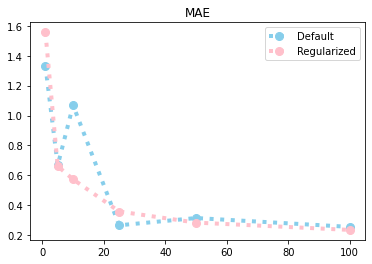

In [64]:
df=pd.DataFrame({'x_values': iterations_set, 'Default': results_def,
                                             'Regularized': results_reg})
plt.plot( 'x_values', 'Default', data=df, marker='o', markerfacecolor='skyblue', markersize=8, color='skyblue', linewidth=4, linestyle='dotted')
plt.plot( 'x_values', 'Regularized', data=df, marker='o', markerfacecolor='pink', markersize=8, color='pink', linewidth=4, linestyle='dotted')
plt.title("MAE")
plt.legend()

Widzimy, że obie sieci osiągnęły bardzo podobne rezultaty, jednak sieć z regularyzacją zbiegła szybciej.

## Rings5 

In [65]:
train_df = pd.read_csv('mio_data/classification/rings5-regular-training.csv')
test_df = pd.read_csv('mio_data/classification/rings5-regular-test.csv')

normalized_train_df=(train_df-train_df.mean())/train_df.std()
normalized_test_df=(test_df-test_df.mean())/test_df.std()


x = np.asarray(normalized_train_df[['x', 'y']])
x_test = np.asarray(normalized_test_df[['x', 'y']])
c = np.asarray(train_df['c']).reshape(-1, 1)
c_test = np.asarray(test_df['c']).reshape(-1, 1)

encoded = to_categorical(c)

In [66]:
iterations_set = [1,5,10,25,50,100]

In [67]:
layers = [2, 16,16, 5]

results_def = []
results_reg = []

for iterations in iterations_set:
    for _ in range (2):
        results_def_temp = []
        results_reg_temp = []
        
        mlp_def = MLP(
        layers = layers, 
        weights_biases = "Xavier",
        activation_function = "tanh", 
        softmax_method = True)

        mlp_def.learn(x, encoded, iterations=iterations, batch_size = 20, 
                          alpha=0.01, var=0.9, method = "Momentum", lambda_=0, inc_stop = True)
        results_def_temp.append(accuracy_score(c_test, mlp_def.classify(x_test)))

        mlp_reg = MLP(
        layers = layers, 
        weights_biases = "Xavier",
        activation_function = "tanh", 
        softmax_method = True)

        mlp_reg.learn(x, encoded, iterations=iterations, batch_size = 20, 
                       alpha=0.1, var=0.9, method = "Momentum", lambda_=1, inc_stop = True)
        results_reg_temp.append(accuracy_score(c_test, mlp_reg.classify(x_test)))

    results_def.append(np.mean(results_def_temp))
    results_reg.append(np.mean(results_reg_temp))

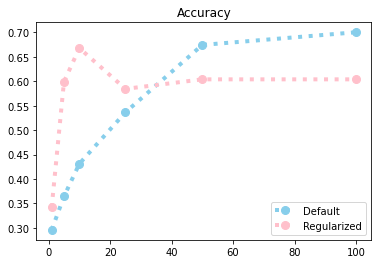

In [68]:
df=pd.DataFrame({'x_values': iterations_set, 'Default': results_def,
                                             'Regularized': results_reg})
plt.plot( 'x_values', 'Default', data=df, marker='o', markerfacecolor='skyblue', markersize=8, color='skyblue', linewidth=4, linestyle='dotted')
plt.plot( 'x_values', 'Regularized', data=df, marker='o', markerfacecolor='pink', markersize=8, color='pink', linewidth=4, linestyle='dotted')
plt.title("Accuracy")
plt.legend()

W tym przypadku sieć regularyzowana poradziła sobie gorzej od domyślnej. Może to wynikać ze struktury zbioru.

## Rings3

In [54]:
train_df = pd.read_csv('mio_data/classification/rings3-balance-training.csv')
test_df = pd.read_csv('mio_data/classification/rings3-balance-test.csv')

normalized_train_df=(train_df-train_df.mean())/train_df.std()
normalized_test_df=(test_df-test_df.mean())/test_df.std()


x = np.asarray(normalized_train_df[['x', 'y']])
x_test = np.asarray(normalized_test_df[['x', 'y']])
c = np.asarray(train_df['c']).reshape(-1, 1)
c_test = np.asarray(test_df['c']).reshape(-1, 1)

encoded = to_categorical(c)

In [55]:
iterations_set = [1,5,10,25,50,100]

In [56]:
layers = [2, 16,16, 3]

results_def = []
results_reg = []

for iterations in iterations_set:
    for _ in range (2):
        results_def_temp = []
        results_reg_temp = []
        
        mlp_def = MLP(
        layers = layers, 
        weights_biases = "Xavier",
        activation_function = "tanh", 
        softmax_method = True)

        mlp_def.learn(x, encoded, iterations=iterations, batch_size = 20, 
                          alpha=0.01, var=0.9, method = "Momentum", lambda_=0, inc_stop = True)
        results_def_temp.append(accuracy_score(c_test, mlp_def.classify(x_test)))

        mlp_reg = MLP(
        layers = layers, 
        weights_biases = "Xavier",
        activation_function = "tanh", 
        softmax_method = True)

        mlp_reg.learn(x, encoded, iterations=iterations, batch_size = 20, 
                       alpha=0.1, var=0.9, method = "Momentum", lambda_=1, inc_stop = True)
        results_reg_temp.append(accuracy_score(c_test, mlp_reg.classify(x_test)))

    results_def.append(np.mean(results_def_temp))
    results_reg.append(np.mean(results_reg_temp))

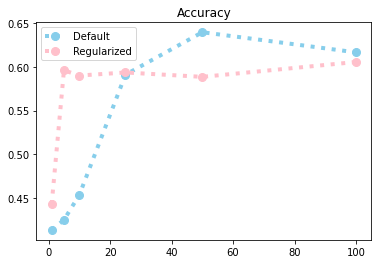

In [57]:
df=pd.DataFrame({'x_values': iterations_set, 'Default': results_def,
                                             'Regularized': results_reg})
plt.plot( 'x_values', 'Default', data=df, marker='o', markerfacecolor='skyblue', markersize=8, color='skyblue', linewidth=4, linestyle='dotted')
plt.plot( 'x_values', 'Regularized', data=df, marker='o', markerfacecolor='pink', markersize=8, color='pink', linewidth=4, linestyle='dotted')
plt.title("Accuracy")
plt.legend()

W tym przypadku lepiej wypadła sieć domyślna, jednak warto zwrócić uwagę, że sieć regularyzowana zbiegła bardzo szybko w porównaniu do domyślnej. 

## XOR3

In [69]:
train_df = pd.read_csv('mio_data/classification/xor3-balance-training.csv')
test_df = pd.read_csv('mio_data/classification/xor3-balance-test.csv')

normalized_train_df=(train_df-train_df.mean())/train_df.std()
normalized_test_df=(test_df-test_df.mean())/test_df.std()


x = np.asarray(normalized_train_df[['x', 'y']])
x_test = np.asarray(normalized_test_df[['x', 'y']])
c = np.asarray(train_df['c']).reshape(-1, 1)
c_test = np.asarray(test_df['c']).reshape(-1, 1)

encoded = to_categorical(c)

In [70]:
iterations_set = [1,5,10,25,50,100]

In [71]:
layers = [2, 16,16, 2]

results_def = []
results_reg = []

for iterations in iterations_set:
    for _ in range (2):
        results_def_temp = []
        results_reg_temp = []
        
        mlp_def = MLP(
        layers = layers, 
        weights_biases = "Xavier",
        activation_function = "tanh", 
        softmax_method = True)

        mlp_def.learn(x, encoded, iterations=iterations, batch_size = 20, 
                          alpha=0.01, var=0.9, method = "Momentum", lambda_=0, inc_stop = True)
        results_def_temp.append(accuracy_score(c_test, mlp_def.classify(x_test)))

        mlp_reg = MLP(
        layers = layers, 
        weights_biases = "Xavier",
        activation_function = "tanh", 
        softmax_method = True)

        mlp_reg.learn(x, encoded, iterations=iterations, batch_size = 20, 
                       alpha=0.1, var=0.9, method = "Momentum", lambda_=1, inc_stop = True)
        results_reg_temp.append(accuracy_score(c_test, mlp_reg.classify(x_test)))

    results_def.append(np.mean(results_def_temp))
    results_reg.append(np.mean(results_reg_temp))

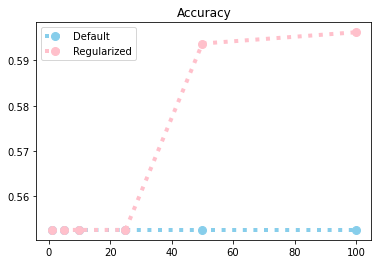

In [72]:
df=pd.DataFrame({'x_values': iterations_set, 'Default': results_def,
                                             'Regularized': results_reg})
plt.plot( 'x_values', 'Default', data=df, marker='o', markerfacecolor='skyblue', markersize=8, color='skyblue', linewidth=4, linestyle='dotted')
plt.plot( 'x_values', 'Regularized', data=df, marker='o', markerfacecolor='pink', markersize=8, color='pink', linewidth=4, linestyle='dotted')
plt.title("Accuracy")
plt.legend()

Bardzo ciekawy eksperyment, widzimy, że zwykład sieć wyraźnie nie radzi sobie z tym zbiorem, natomiast sieć z regularyzacją wychodzi obronną ręką.